In [ ]:
import sys
import smbus
import time
import atexit
import threading
from dbm import DBMeter
from picamera2 import Picamera2
from picamera2.encoders import H264Encoder, Encoder
from picamera2.outputs import CircularOutput
import concurrent.futures
from buffered_output import BufferedOutput
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
import cv2
from matplotlib import animation
from datetime import datetime
import os
###############################################
# Camera setup.
picam2 = Picamera2()
fps = 24
dur = 10
micro = int((1 / fps) * 1000000)
vconfig = picam2.create_video_configuration()
vconfig['controls']['FrameDurationLimits'] = (micro, micro)
#vconfig['main']['size']=(1920,1080)
encoder = Encoder()
picam2.configure(vconfig)
interval = 0.125
##############
video_file_increment = 0;
output = BufferedOutput(buffersize=int(fps * (dur + 0.2)), outputtofile=False)
from matplotlib import pyplot as plt
import cv2
from smb.SMBConnection import SMBConnection


def cleanup():
    picam2.stop_recording()
    picam2.stop_()
    picam2.close()

def startLoop():
    threading.Timer(interval,startLoop).start()
    a.capture()

def reportTimeBrackets(ts,arr):
    print("time now:", end=" ")
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print("video start: ", end=" ")
    print(ts[0].strftime("%Y-%m-%d %H:%M:%S"))
    print("video end: ", end=" ")
    print(ts[-1].strftime("%Y-%m-%d %H:%M:%S"))
    print("data start: ", end=" ")
    print(arr[0,0].strftime("%Y-%m-%d %H:%M:%S"))
    print("data end: ", end=" ")
    print(arr[-1,0].strftime("%Y-%m-%d %H:%M:%S"))
    
    

def produceBaseFigure(trigger_time_string,plot_lims,sz):
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8),gridspec_kw={'height_ratios':[3,1],'hspace':0.05,'wspace':0.05})
    ax1.axis('off')
    img = ax1.imshow(np.zeros((sz[1],sz[0],4),np.uint8))
    fig.set_dpi(100)
    fig.suptitle("Capture Triggered at: " + trigger_time_string + " UTC Time\n" +
                 "Red line on plot is 76 dBA limit per MCL 257.707c(1)(c)(ii).\n" + 
                 "Orange lines are per residential noise limits, Sec. 46-181 for Day (55 dBA) and Night (50 dBA) per table.\n" +
                 "Sensor has accuracy +/- 2dB. Set to 'A' weighted network and sampled over 125ms(ANSI S1.4-1971).")
    ax2.grid(b=True, which='major', color='k', linestyle='-')
    ax2.axhline(y=76,color='r')
    ax2.axhline(y=55,color='tab:orange')
    ax2.axhline(y=50,color='tab:orange')
    ax2.set_ylabel('Sound Level [dBA]')
    db_line, = ax2.plot([],[], color="b")
    ax2.set_xlim(plot_lims[0], plot_lims[1])
    ax2.set_ylim(plot_lims[2], plot_lims[3])
    return fig, img, db_line
    
def animate(i,img, db_line,arr,video_frames,timestamp_deque,sz):
    img.set_array(np.reshape(np.frombuffer(video_frames[i], dtype=np.uint8),(sz[1],sz[0],4)))
    #find latest timestamp
    x_data =[]
    y_data =[]
    ts = timestamp_deque[i]
    k = 0; 
    while arr[k,0] < ts and k < len(arr[:,0]) : 
        x_data.append(arr[k,0])
        y_data.append(arr[k,1])
        k=k+1
    db_line.set_data(x_data,y_data)
    return [db_line, img]

def generateVideoViaFunc(data_buffer,video_frames,timestamp_deque,vconfig):
    video_frames_l = video_frames.copy()
    ts_deque = timestamp_deque.copy()
    arr = np.asarray(data_buffer)
    #reportTimeBrackets(ts_deque,arr)
    sz = vconfig['main']['size']
    # store generated images
    frames = [] 
    # pull the data in as a np array
    db_max = arr.max(axis=0)[1]
    db_min = arr.min(axis=0)[1]
    plot_lims = [ts_deque[0],ts_deque[-1],db_min-2, max(db_max+2,80)]
    trigger_data_frame = 0
    for i in range(len(data_buffer)):
        if data_buffer[i][1] > 70:
            trigger_data_frame = i
            print(i, end=" ")
            print("is trigger frame")
            break
    
    # set the title
    fig, img, db_line = produceBaseFigure(arr[trigger_data_frame,0].strftime("%Y-%m-%d %H:%M:%S"),plot_lims,sz)      
    time.sleep(0.05)            
    ani = animation.FuncAnimation(fig, animate, frames=len(video_frames_l), fargs=(img, db_line,arr,video_frames_l,ts_deque,sz), interval=41.6, blit=True)
    writergif = animation.PillowWriter(fps=24)
    date_name = arr[trigger_data_frame,0].strftime("%Y_%m_%d_%H_%M_%S") + ".gif"
    output_file = "/dev/shm/" + date_name
    ani.save(output_file,writer=writergif)
    file_obj = open(output_file,'rb')
    conn = SMBConnection("soundmeter","ihearyou","soundmeter", "boxotubes", use_ntlm_v2 = True)
    conn.connect('192.168.1.10')
    ret = conn.storeFile('SoundMeter', date_name, file_obj)
    if ret > 0:
        print("upload sucess")
    else:
        print("upload fail")
    conn.close()
    file_obj.close()
    os.remove(output_file)


if (__name__ == "__main__"):
    atexit.register(cleanup)
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        while True:
            print("restarting loop")
            output.reset()
            picam2.start_recording(encoder, output)
            a = DBMeter("sound_meter_thread")
            a.set_queue_duration(10)
            a.start()
            a.join()
            #print("stop camera enter: " + datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
            #print("reference time was: ", end=" ")
            #print(output.reference_time.strftime("%Y-%m-%d %H:%M:%S"))
            picam2.stop_recording()
            output.stop()
            #print("stop camera exit: " + datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
            #print('exiting thread')
            executor.submit(generateVideoViaFunc,a.fifo.copy(),output.getFrames(),output.getTimestamps(),vconfig)
            #generateVideoViaFunc(hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)
    cleanup()


        
    

[4:36:29.364419228] [5453]  INFO Camera camera.cpp:1033 configuring streams: (0) 1280x720-XBGR8888 (1) 1920x1080-SBGGR10_CSI2P
[4:36:29.364958422] [5449]  INFO RPI vc4.cpp:565 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 1920x1080-SBGGR10_1X10 - Selected unicam format: 1920x1080-pBAA


restarting loop
dbMeter VERSION = 0x31
Unique ID: 0x3571729f 
restarting loop28 is trigger frame

dbMeter VERSION = 0x31
Unique ID: 0xb571729f 
restarting loop38 is trigger frame

dbMeter VERSION = 0x31
Unique ID: 0x3571729f 
upload sucess
restarting loop
38 is trigger frame
dbMeter VERSION = 0x31
Unique ID: 0x3571729f 
25restarting loop
dbMeter VERSION = 0x31
Unique ID: 0x3571729f 
 is trigger frame
12restarting loop
dbMeter VERSION = 0x31
Unique ID: 0xb571729f 
 is trigger frame
restarting loop
dbMeter VERSION = 0x31
Unique ID: 0x3571729f 
38 is trigger frame
restarting loop
dbMeter VERSION = 0x31
Unique ID: 0x3571729f 


(80, 2)
[[datetime.datetime(2023, 12, 15, 14, 31, 16, 219048) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 344139) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 471908) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 597004) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 722615) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 847699) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 16, 973230) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 98346) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 223568) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 348651) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 473763) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 598860) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 723949) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 849090) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 17, 974181) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 18, 99292) 41]
 [datetime.datetime(2023, 12, 15, 14, 31, 18, 224387) 41]
 [dateti

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

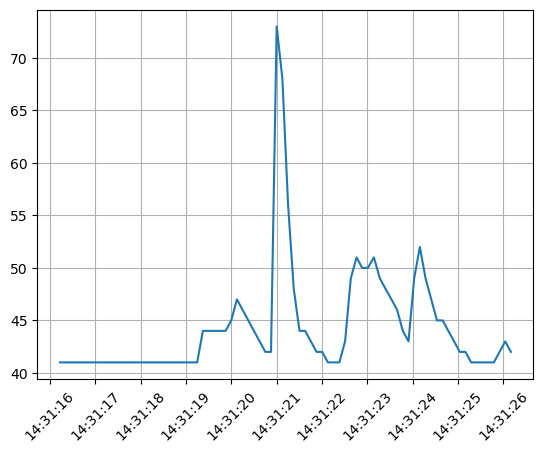

In [15]:
import numpy as np
test_arr = np.asarray(a.fifo)
print(np.shape(test_arr))
print(test_arr)
#plt.setp(labels, rotation=90)
plt.plot(test_arr[:,0],test_arr[:,1])
plt.grid(b='on')
plt.xticks(rotation=45)
plt.title

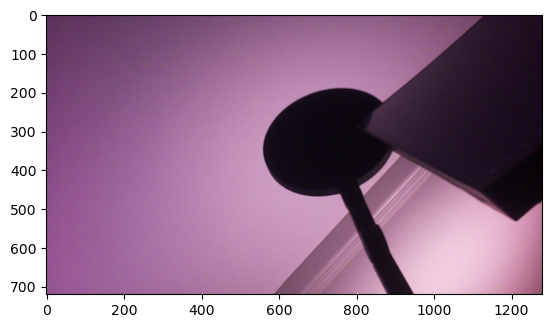

In [3]:
d_out = output.getFrames()
a = d_out.popleft()
sys.getsizeof(a)
# convert to numpy array 
image = np.asarray(bytearray(a)) 
sz=vconfig['main']['size']
image = np.reshape(image, (sz[1],sz[0],4))
#image = image[:,:,:3]
#image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
#imageRGB = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
# display image 
plt.imshow(image)
#plt.pcolormesh(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
type(memoryview(output.getFrames()[1][0]))

In [ ]:
generateVideo(hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)

In [5]:
cleanup()

In [ ]:
len(output.getFrames())

In [ ]:
generateVideoViaFunc(hold_fifo,output.getFrames(),output.getTimestamps(),vconfig)

In [6]:
conn.close()

In [3]:
file_obj = open('/dev/shm/2023_12_15_18_10_22.gif','rb')
conn = SMBConnection("soundmeter","ihearyou","soundmeter", "boxotubes", use_ntlm_v2 = True)
conn.connect('192.168.1.10')
ret = conn.storeFile('SoundMeter', '2023_12_15_18_10_22.gif', file_obj)
if ret > 0:
    print("upload sucess")
else:
    print("upload fail")
conn.close()

upload sucess
